<a name="top"></a>

# Using R in SageMaker Processing

This
[notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/r_examples/r_in_sagemaker_processing/r_in_sagemaker_processing.ipynb)
was originally downloaded from the
[Amazon SageMaker Examples](https://github.com/aws/amazon-sagemaker-examples)
GitHub repo.

Last updated January 16, 2022 by [Michael Burkhardt](mailto:michael@monkeywalk.com)

---

Amazon SageMaker Processing is a capability of Amazon SageMaker that lets you easily run your preprocessing, postprocessing and model evaluation workloads on fully managed infrastructure.  In this example, we'll see how to use SageMaker Processing with the R programming language.

The workflow for using R with SageMaker Processing involves the following steps:

1. [Write an R script](#step1)
2. [Build a Docker container](#step2)
3. [Create a SageMaker Processing job](#step3)
4. [Retrieve and view job results](#step4)

<a name="step1"></a>
<div align="right"><a href="#top">Return to top</a></div>

## 1. Write an R script

To use R with SageMaker Processing, first prepare an R script similar to one you would use
outside SageMaker. Below is the R script we'll be using. It performs operations on data and
also saves a `.png` of a plot for retrieval and display later after the Processing job is
complete. This enables you to perform any kind of analysis and feature engineering at scale
with R, and also create visualizations for display anywhere.

In [1]:
%%writefile preprocessing.R

library(readr)
library(dplyr)
library(ggplot2)
library(forcats)

input_dir <- "/opt/ml/processing/input/"
filename <- Sys.glob(paste(input_dir, "*.csv", sep=""))
df <- read_csv(filename)

plot_data <- df %>%
  group_by(state) %>%
  count()

write_csv(plot_data, "/opt/ml/processing/csv/plot_data.csv")

plot <- plot_data %>% 
  ggplot()+
  geom_col(aes(fct_reorder(state, n), 
               n, 
               fill = n))+
  coord_flip()+
  labs(
    title = "Number of people by state",
    subtitle = "From US-500 dataset",
    x = "State",
    y = "Number of people"
  )+ 
  theme_bw()

ggsave("/opt/ml/processing/images/census_plot.png", width = 10, height = 8, dpi = 100)

Writing preprocessing.R


<a name="step2"></a>
<div align="right"><a href="#top">Return to top</a></div>

## 2. Build a Docker container

Next, there is a one-time step to create a R container.  For subsequent SageMaker Processing jobs, you can just reuse this container (unless you need to add further dependencies, in which case you can just add them to the Dockerfile and rebuild).  To start, set up a local directory for Docker-related files.

In [2]:
!mkdir docker

A simple Dockerfile can be used to build a Docker container for SageMaker Processing.  For this example, we'll use a parent Docker image from the Rocker Project, which provides a set of convenient R Docker images.  There is no need to include your R script in the container itself because SageMaker Processing will ingest it for you.  This gives you the flexibility to modify the script as needed without having to rebuild the Docker image every time you modify it.  

In [3]:
%%writefile docker/Dockerfile

FROM rocker/tidyverse:latest

# tidyverse has all the packages we need, otherwise we could install more as follows
# RUN install2.r --error \
#    jsonlite \
#    tseries

ENTRYPOINT ["Rscript"]

Writing docker/Dockerfile


The Dockerfile is now used to build the Docker image.  We'll also create an Amazon Elastic Container Registry (ECR) repository, and push the image to ECR so it can be accessed by SageMaker.

In [4]:
import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
region = boto3.session.Session().region_name

ecr_repository = "r-in-sagemaker-processing"
tag = ":latest"

uri_suffix = "amazonaws.com"
processing_repository_uri = "{}.dkr.ecr.{}.{}/{}".format(
    account_id, region, uri_suffix, ecr_repository + tag
)
print(processing_repository_uri)

400999793714.dkr.ecr.us-east-2.amazonaws.com/r-in-sagemaker-processing:latest


In [8]:
# Build Docker image - This may take a few minutes
!docker build -t $ecr_repository docker

Sending build context to Docker daemon  2.048kB
Step 1/2 : FROM rocker/tidyverse:latest
latest: Pulling from rocker/tidyverse

2f368469: Pulling fs layer 
401695eb: Pulling fs layer 
33e47f6e: Pulling fs layer 
05187ae7: Pulling fs layer 
7b8a28d5: Pulling fs layer 
0d504ab3: Pulling fs layer 
c38ee934: Pulling fs layer 
Digest: sha256:ae2f79590f6be4ed333fb59dd48410aa4e110e1399325c2fa66a76d150129f74[4A
Status: Downloaded newer image for rocker/tidyverse:latest
 ---> ce04595a2cd5
Step 2/2 : ENTRYPOINT ["Rscript"]
 ---> Running in 560c51a35065
Removing intermediate container 560c51a35065
 ---> 6e1d64718265
Successfully built 6e1d64718265
Successfully tagged r-in-sagemaker-processing:latest


In [9]:
# Get login helper
!aws ecr get-login-password | docker login --username AWS --password-stdin {processing_repository_uri}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [10]:
# Create ECR repository (can skip if already exists)
!aws ecr create-repository --repository-name {ecr_repository} --image-scanning-configuration scanOnPush=true


An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'r-in-sagemaker-processing' already exists in the registry with id '400999793714'


In [11]:
!docker tag {ecr_repository + tag} {processing_repository_uri}

In [12]:
!docker push {processing_repository_uri}

The push refers to repository [400999793714.dkr.ecr.us-east-2.amazonaws.com/r-in-sagemaker-processing]

6edb7704: Preparing 
25795ee4: Preparing 
ff4f3119: Preparing 
5ac593d6: Preparing 
d3bc682a: Preparing 
23f81aad: Preparing 
b80b925b: Preparing 


ff4f3119: Pushing  697.8MB/1.04GBBPushing  201.1MB/1.04GB

23f81aad: Pushed     788MB/778.9MBlatest: digest: sha256:1a7c77aa793842c2b76f8abd0afabaf4755f455ac93696075e7b43d98c1b0d21 size: 2001


<a name="step3"></a>
<div align="right"><a href="#top">Return to top</a></div>

## 3. Create a SageMaker Processing job

With our Docker image in ECR, we now prepare for the SageMaker Processing job by specifying Amazon S3 buckets for output and input, and downloading the raw dataset.

In [13]:
import sagemaker
from sagemaker import get_execution_role

In [14]:
role = get_execution_role()
print(role)

arn:aws:iam::400999793714:role/MWSageMakerRole


In [15]:
session = sagemaker.Session()
print(session.default_bucket())

sagemaker-us-east-2-400999793714


In [16]:
# Download some sample data from SageMaker Workshop bucket
!aws s3 cp s3://sagemaker-workshop-pdx/R-in-Processing/us-500.csv ./data/us-500.csv

download: s3://sagemaker-workshop-pdx/R-in-Processing/us-500.csv to data/us-500.csv


### Upload the script and the data

Before setting up the SageMaker Processing job, the raw dataset is uploaded to an S3
bucket _that we own_ so it is accessible to our SageMaker Processing job. This happens
to be the same as the session.default_bucket() but I'm specifying it explicitly.

In [22]:
my_s3_bucket = "sagemaker-us-east-2-400999793714"
my_s3_prefix = "R-in-Processing"

data_s3 = session.upload_data(
    path="./data",
    bucket=my_s3_bucket,
    key_prefix="{}/data".format(my_s3_prefix)
)
print(data_s3)

s3://sagemaker-us-east-2-400999793714/R-in-Processing/data


In addition, I'm also going to upload the R script to S3 beforehand. This is optional,
but if you skip this step the ScriptProcessor will store the script on S3 in a _new_
folder based on the job name every time you run and you'll end up with a whole bunch
of folders with duplicate copies of the script.

In [23]:
script_s3 = session.upload_data(
    path="preprocessing.R",
    bucket=my_s3_bucket,
    key_prefix="{}/script".format(my_s3_prefix)
)
print(script_s3)

s3://sagemaker-us-east-2-400999793714/R-in-Processing/script/preprocessing.R


The `ScriptProcessor` class of the SageMaker SDK lets you run a command inside a Docker container.  We'll use this to run our own script using the `Rscript` command.  In the `ScriptProcessor` you also can specify the type and number of instances to be used in the SageMaker Processing job.

In [18]:
from sagemaker.processing import ScriptProcessor

script_processor = ScriptProcessor(
    command=["Rscript"],
    image_uri=processing_repository_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
)

We can now start the SageMaker Processing job.  The main aspects of the code below are specifying the input and output locations, and the name of our R preprocessing script.  

In [25]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from time import gmtime, strftime

processing_job_name = "R-in-Processing-{}".format(strftime("%Y%m%d-%H%M%S", gmtime()))
output_destination = "s3://{}/{}/output".format(my_s3_bucket, my_s3_prefix)

script_processor.run(
    code=script_s3,
    job_name=processing_job_name,
    inputs=[
        ProcessingInput(
            source=data_s3,
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="csv",
            destination="{}/csv".format(output_destination),
            source="/opt/ml/processing/csv",
        ),
        ProcessingOutput(
            output_name="images",
            destination="{}/images".format(output_destination),
            source="/opt/ml/processing/images",
        ),
    ],
)

preprocessing_job_description = script_processor.jobs[-1].describe()


Job Name:  R-in-Processing-20220116-152936
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-400999793714/R-in-Processing/data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-400999793714/R-in-Processing/script/preprocessing.R', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'csv', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-400999793714/R-in-Processing/output/csv', 'LocalPath': '/opt/ml/processing/csv', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'images', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-400999793714/R-in-Processing/

<a name="step4"></a>
<div align="right"><a href="#top">Return to top</a></div>

## 4. Retrieve and view job results

From the SageMaker Processing job description, we can look up the S3 URIs of the output, including the output plot .png file.

In [26]:
output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "csv":
        preprocessed_csv_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "images":
        preprocessed_images = output["S3Output"]["S3Uri"]

Now we can display the plot produced by the SageMaker Processing job.  A similar workflow applies to retrieving and working with any other output from a job, such as the transformed data itself.  

download: s3://sagemaker-us-east-2-400999793714/R-in-Processing/output/images/census_plot.png to ./census_plot.png


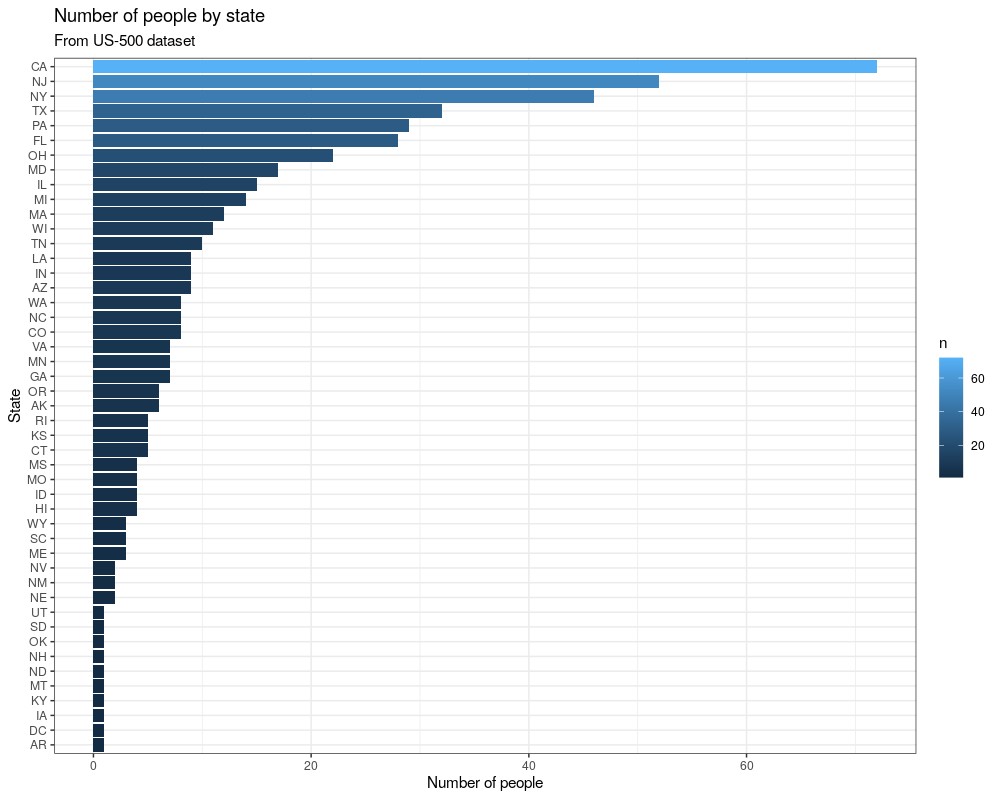

In [27]:
from PIL import Image
from IPython.display import display

plot_key = "census_plot.png"
plot_in_s3 = "{}/{}".format(preprocessed_images, plot_key)
!aws s3 cp {plot_in_s3} .
im = Image.open(plot_key)
display(im)